In [10]:
import seaborn as sns
from software.data_collector import get_data_for_period
from software.data_processor import process_data
from software.backtester import run_back_test
from software.plotter import plot_bollinger_bands, plot_ema_and_sma, plot_rsi, plot_atr, plot_signals
from software.strategy import Strategy
from software.tasks import execute_trades
from software.analysis import evaluate_performance

%matplotlib inline
sns.set_style('darkgrid')

ticker = "BTC-USD"
start_date = "2024-11-03 12:00:00"
end_date = "2024-11-03 20:30:00"
interval = "1m"

sma_period=5
ema_period=20
rsi_period=7
bbands_period=20
atr_period=14

initial_cash = 1000
transaction_cost = 0.001
leverage=1
slippage_pct=0.0005
risk_per_trade=0.02

data = get_data_for_period(ticker=ticker, start_date=start_date, end_date=end_date, interval=interval)
processed_data = process_data(
    data,
    sma_period=sma_period,
    ema_period=ema_period,
    rsi_period=rsi_period,
    bbands_period=bbands_period,
    atr_period=atr_period,
)

strategy = Strategy(
    ema_sma_threshold=0,
    rsi_long_threshold=40,
    rsi_short_threshold=60,
    bb_threshold=0,
)


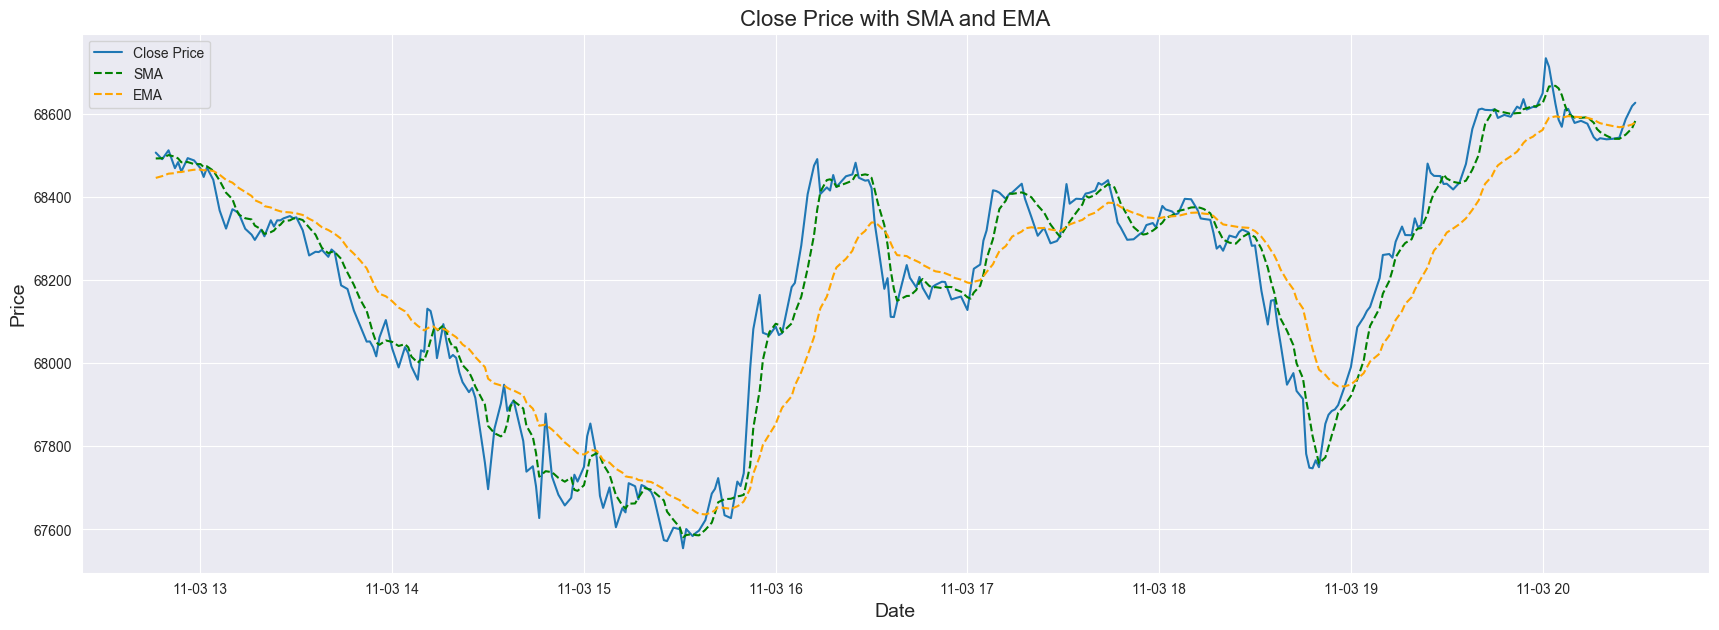

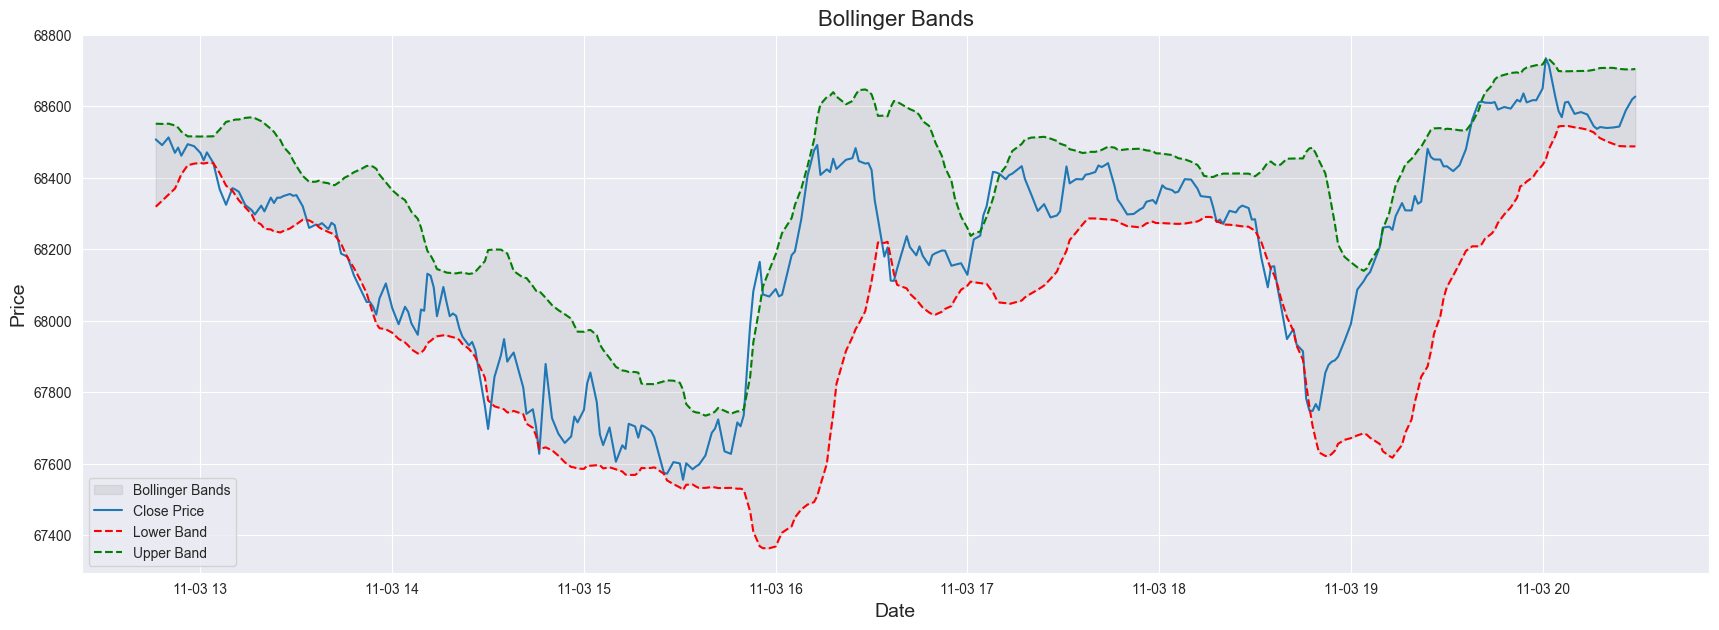

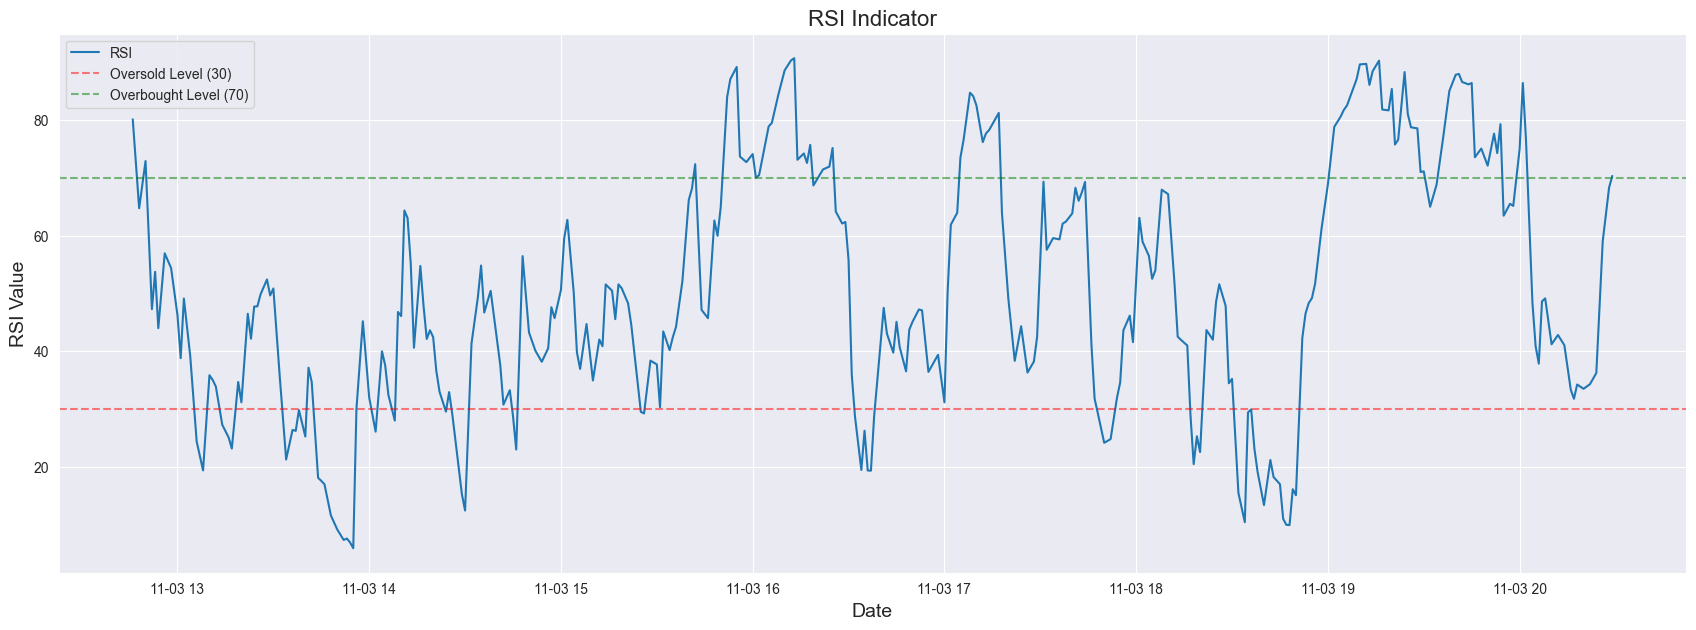

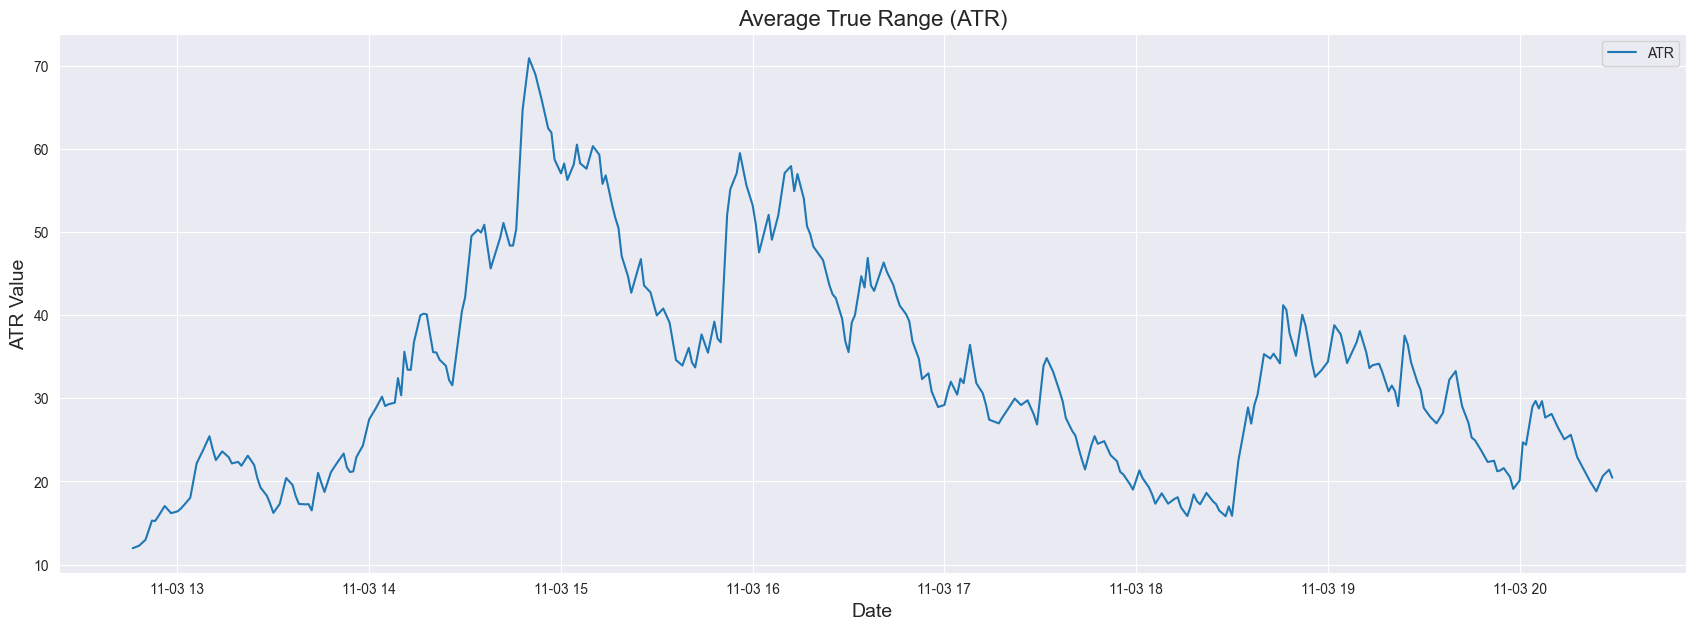

In [11]:
plot_ema_and_sma(processed_data)
plot_bollinger_bands(processed_data)
plot_rsi(processed_data)
plot_atr(processed_data)

In [12]:
data_with_signals = strategy.generate_buy_signals(processed_data)

Signals : [-1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 0, -1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 

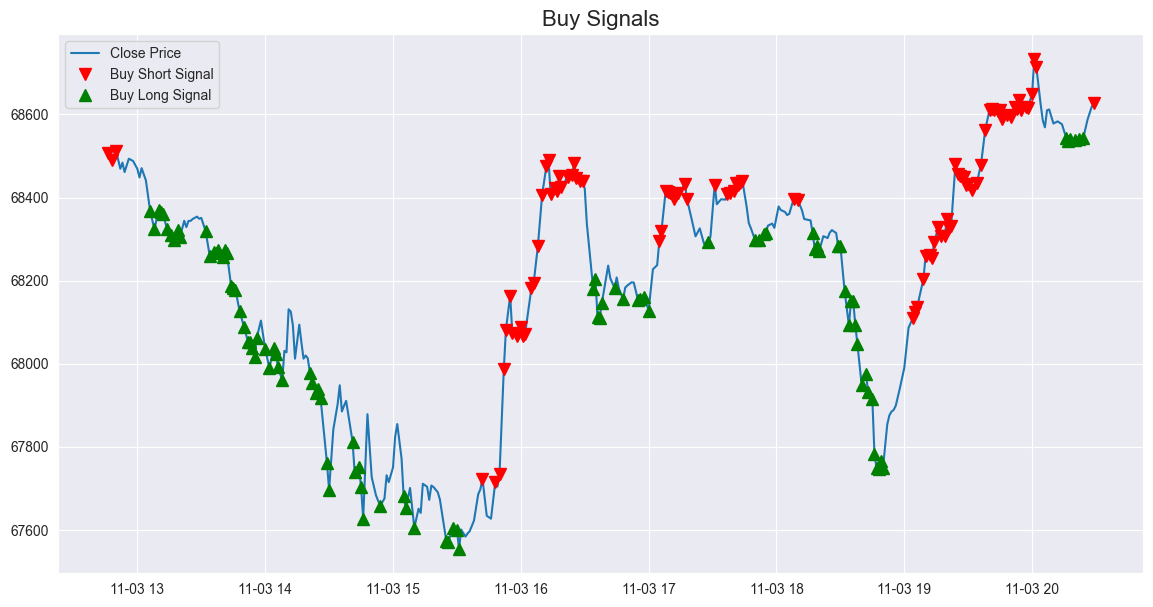

In [13]:
print("Signals :", data_with_signals["Signal"].tolist())
plot_signals(processed_data)

In [14]:
# transactions, equity_curve, dates = execute_trades(
#     data=data_with_signals,
#     initial_cash=initial_cash,
#     transaction_cost=transaction_cost,
#     leverage=leverage,
#     slippage_pct=slippage_pct,
#     risk_per_trade=risk_per_trade,
# )

from software.executor import TradingExecutor
from tqdm import tqdm

executor = TradingExecutor(
    initial_cash=initial_cash,
    transaction_cost=transaction_cost,
    leverage=leverage,
    slippage_pct=slippage_pct,
    risk_per_trade=risk_per_trade,
)

transactions = []
equity_curve = []
dates = []

print("Executor :", executor.__dict__)

Executor : {'cash': 1000, 'transaction_cost': 0.001, 'leverage': 1, 'slippage_pct': 0.0005, 'risk_per_trade': 0.02, 'positions': [], 'history': []}


In [15]:
for index, row in tqdm(
    data_with_signals.iterrows(),
    total=len(data_with_signals),
    desc="Executing trades",
):
    signal = row["Signal"]
    price = row["Close"]
    atr_stop_loss = row["ATR"] * 2

    date = index

    print(f"Signal: {signal}, Price: {price}, ATR Stop Loss: {atr_stop_loss}, Date: {date}")

    executor.execute_signal(
        signal,
        price,
        atr_stop_loss,
        date,
    )
    executor.update_positions(price, date, atr_stop_loss)

    if executor.history and (
        not transactions or executor.history[-1] != transactions[-1]
    ):
        last_transaction = executor.history[-1]
        transactions.append(last_transaction)

    total_value = executor.get_total_portfolio_value(price)
    equity_curve.append(total_value)
    dates.append(date)

Executing trades: 100%|████████████████████| 316/316 [00:00<00:00, 20661.92it/s]

Signal: -1.0, Price: 68506.71875, ATR Stop Loss: 23.934284070808335, Date: 2024-11-03 12:46:00+00:00
Buy Short signal
Stop loss price:  68530.65303407081
Size in USDT:  40.0
Amount:  0.0005841764243744706 BTC/USDT
======= Position opened at:  68472.465390625 =======
Signal: -1.0, Price: 68490.78125, ATR Stop Loss: 24.551125188045354, Date: 2024-11-03 12:48:00+00:00
Buy Short signal
Signal: -1.0, Price: 68512.2265625, ATR Stop Loss: 25.966900351286505, Date: 2024-11-03 12:50:00+00:00
Buy Short signal
Signal: 0.0, Price: 68469.21875, ATR Stop Loss: 30.575957596851232, Date: 2024-11-03 12:52:00+00:00
Price is less than entry price recalculating SL...
--------------- Old stop loss:  68530.65303407081 --------------- New stop loss:  68530.3706651937 Price:  68469.21875 ATR:  30.575957596851232
Signal: 0.0, Price: 68483.875, ATR Stop Loss: 30.479494375597476, Date: 2024-11-03 12:53:00+00:00
Signal: 0.0, Price: 68461.171875, ATR Stop Loss: 31.6135517037149, Date: 2024-11-03 12:54:00+00:00
Pri

In [16]:
print("Transactions :", transactions)
print("Equity curve :", equity_curve)
print("Dates :", dates)

Transactions : [{'action': 'open', 'position_type': 'short', 'price': 68472.465390625, 'amount': 0.0005841764243744706, 'date': Timestamp('2024-11-03 12:46:00+0000', tz='UTC')}, {'action': 'close', 'position_type': 'short', 'price': 68069.73716796875, 'amount': 0.0005841764243744706, 'date': Timestamp('2024-11-03 13:58:00+0000', tz='UTC'), 'pnl': 0.2352643331060155}, {'action': 'open', 'position_type': 'long', 'price': 68069.05658203125, 'amount': 0.0005875002744967147, 'date': Timestamp('2024-11-03 14:00:00+0000', tz='UTC')}, {'action': 'close', 'position_type': 'long', 'price': 67994.20667578124, 'amount': 0.0005875002744967147, 'date': Timestamp('2024-11-03 14:08:00+0000', tz='UTC'), 'pnl': -0.0439743404679313}, {'action': 'open', 'position_type': 'long', 'price': 68011.87957031249, 'amount': 0.0005879683182658631, 'date': Timestamp('2024-11-03 14:21:00+0000', tz='UTC')}, {'action': 'close', 'position_type': 'long', 'price': 67794.56784375, 'amount': 0.0005879683182658631, 'date': T

In [17]:
performance_metrics = evaluate_performance(
    transactions, equity_curve, initial_cash
)

final_portfolio_value = equity_curve[-1]
total_profit = final_portfolio_value - initial_cash
print(f"Total Profit: ${total_profit:.2f}")

Total Profit: $0.33


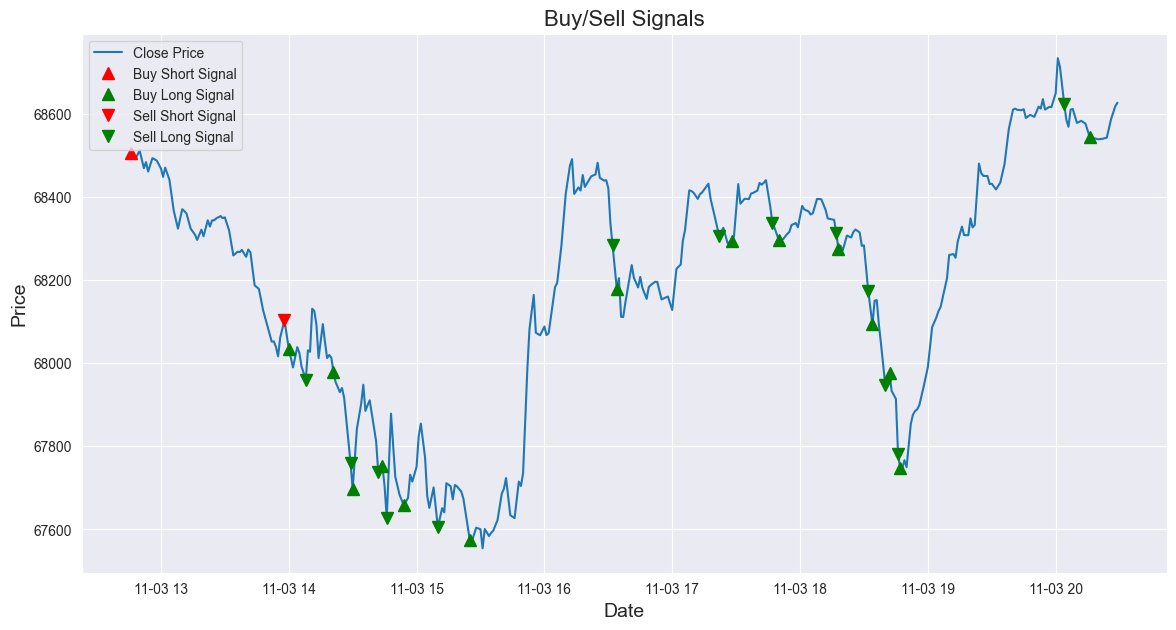

In [18]:
from software.plotter import plot_trades

plot_trades(price_data=processed_data, transactions=transactions)

Have to add update functionality for SL or TP. With trailing stop loss, it will be a good strategy.